## 1. Get the Data
Read data from csv file and output panda DataFrame

In [1]:
import os
import numpy as np
import pandas as pd

def load_data(data_path, file_name):
    csv_path = os.path.join(data_path, file_name)
    return pd.read_csv(csv_path)

In [2]:
KDD_DATA_PATH = "data/NSL-KDD"
kdd20 = load_data(KDD_DATA_PATH, "KDD20Train.csv")
kdd_test = load_data(KDD_DATA_PATH, "KDDTest+.csv")

In [3]:
kdd20.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'attack_type',
'unknown number']

In [4]:
kdd20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25191 entries, 0 to 25190
Data columns (total 43 columns):
duration                       25191 non-null int64
protocol_type                  25191 non-null object
service                        25191 non-null object
flag                           25191 non-null object
src_bytes                      25191 non-null int64
dst_bytes                      25191 non-null int64
land                           25191 non-null int64
wrong_fragment                 25191 non-null int64
urgent                         25191 non-null int64
hot                            25191 non-null int64
num_failed_logins              25191 non-null int64
logged_in                      25191 non-null int64
num_compromised                25191 non-null int64
root_shell                     25191 non-null int64
su_attempted                   25191 non-null int64
num_root                       25191 non-null int64
num_file_creations             25191 non-null int64
num_

In [5]:
# Output: DataFrame
kdd20_data = kdd20.drop(["attack_type", "unknown number"], axis=1)
kdd20_labels = kdd20["attack_type"].copy()

## 2. Discover and Visualize the Data

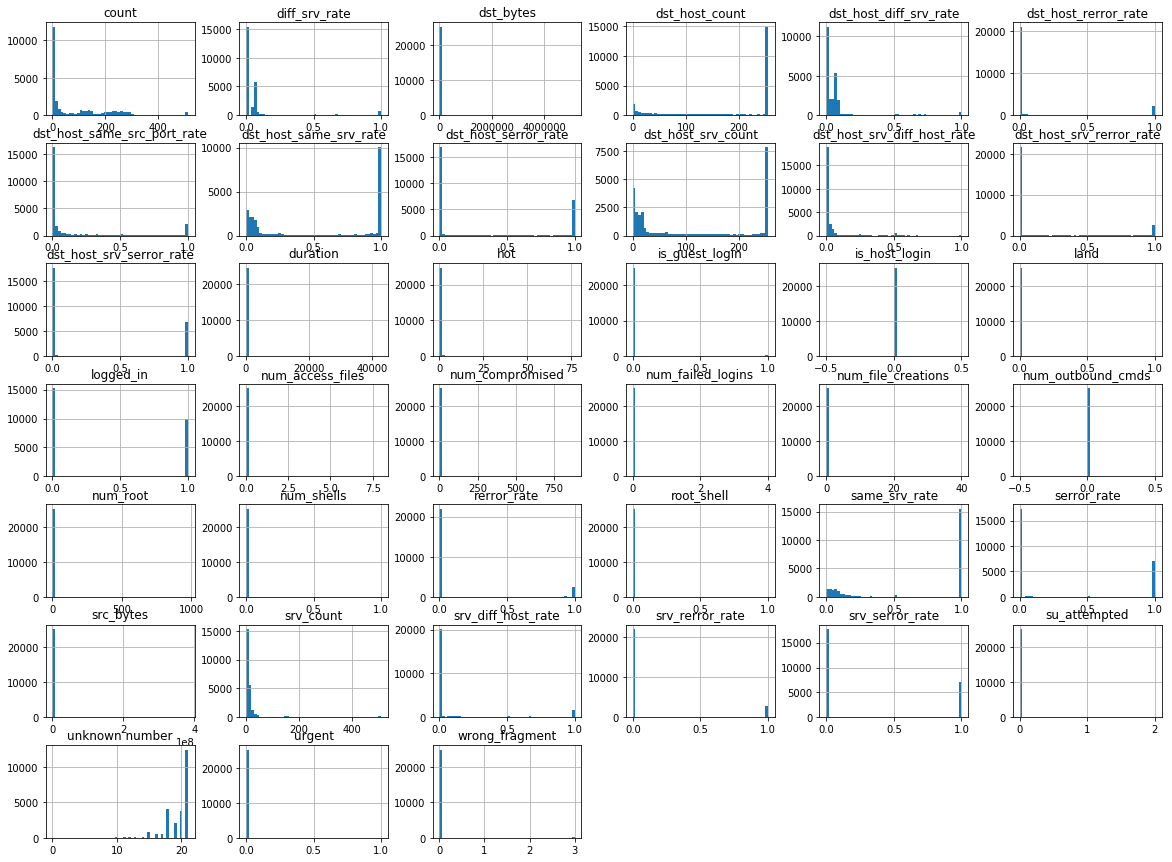

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
kdd20.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
corr_matrix = kdd20.corr()

In [8]:
corr_matrix["land"].sort_values(ascending=False)

land                           1.000000
dst_host_srv_diff_host_rate    0.053037
dst_host_same_src_port_rate    0.024635
dst_host_serror_rate           0.014291
srv_serror_rate                0.014259
serror_rate                    0.014216
srv_diff_host_rate             0.014032
dst_host_same_srv_rate         0.009531
same_srv_rate                  0.006880
dst_host_srv_serror_rate       0.005596
urgent                        -0.000056
src_bytes                     -0.000090
num_shells                    -0.000168
num_root                      -0.000194
num_compromised               -0.000195
num_failed_logins             -0.000234
su_attempted                  -0.000247
num_file_creations            -0.000248
dst_bytes                     -0.000350
root_shell                    -0.000351
num_access_files              -0.000391
wrong_fragment                -0.000813
hot                           -0.000819
is_guest_login                -0.000855
duration                      -0.001012


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11478ca58>,
      dtype=object)

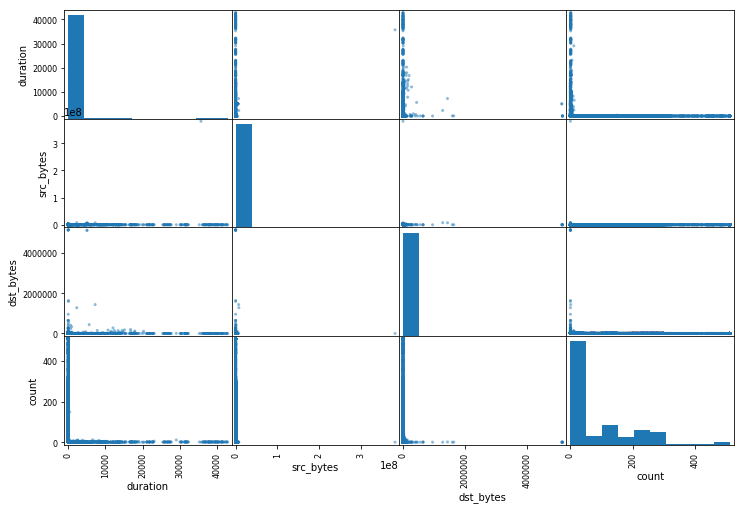

In [9]:
from pandas.plotting import scatter_matrix
attributes = ["duration", "src_bytes", "dst_bytes", "count"]
scatter_matrix(kdd20[attributes], figsize=(12,8))

## 3. Prepare Data

### a. Missing Data
- Get rid of corresponding districts
- Get rid of the whole attribute
- Set the values to some value (zero, the mean, the media, etc.)

### b. Categorical Attributes
- One-hot-encoding

### c. Feature Scaling
- Standarization



1. Separate numric and categoric data
2. Numeric - Scaling
3. Categoric - one hot encoding

In [10]:
kdd20_data_num = kdd20_data.drop(["protocol_type","service","flag"], axis=1)

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(kdd20_data_num)
cat_attribs = ["protocol_type","service","flag"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(n_values='auto')),
    ])

In [13]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ])

In [14]:
kdd20_prepared = full_pipeline.fit_transform(kdd20_data)

### Binary Classification

normal - 1
abnormal - 0

In [15]:
kdd20_bi_labels = (kdd20_labels == 'normal').astype(np.int) # 1- normal 0- attack

## 4. Select and Train Model 
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boost
- Support Vector Machine (SVM)

### A. Logistic Regression

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(kdd20_prepared, kdd20_bi_labels, test_size=0.3, random_state=0)

In [17]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

### Evaluate Training Error

In [19]:
y_pred = log_reg.predict(X_train)

### B. Stochastic Gradient Descent Classifier - Logistic Regression 

In [28]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(loss='log', random_state=27) # loss='log' to use logistic regression
sgd_clf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=27, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [29]:
y_pred = sgd_clf.predict(X_train)

### Confusion Matrix, Precision, Recall, F1

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_pred)

array([[7894,  309],
       [ 177, 9253]])

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [22]:
precision_score(y_train, y_pred)

0.9676845848148923

In [23]:
recall_score(y_train, y_pred)

0.9812301166489926

In [24]:
f1_score(y_train, y_pred)

0.9744102780117945

In [25]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred)

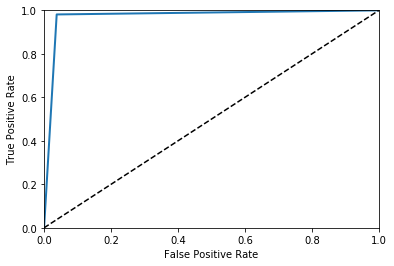

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

## 5. Evaluation - Cross-Validation
Use cross_val_predict().
cross_val_predict performs K-fold cross-validation and returns the predictions made on each test fold.

In [30]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=10, scoring="accuracy")

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([0.96485261, 0.97108844, 0.96655329, 0.9659671 , 0.96483267,
       0.94157686, 0.92909813, 0.94668179, 0.95008508, 0.95235394])

In [31]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=10)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [32]:
confusion_matrix(y_train, y_pred)

array([[7581,  622],
       [ 166, 9264]])

In [33]:
precision_score(y_train, y_pred)

0.9370827432733158

In [34]:
recall_score(y_train, y_pred)

0.9823966065747614

In [35]:
f1_score(y_train, y_pred)

0.95920480430731

In [36]:
kdd20_bi_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=10, method="decision_function")

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


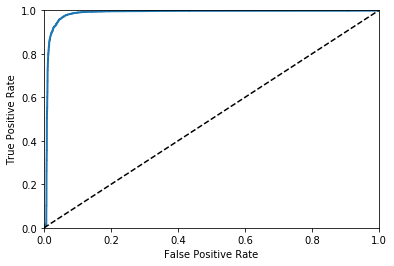

In [37]:
fpr, tpr, thresholds = roc_curve(y_train, kdd20_bi_scores)
plot_roc_curve(fpr, tpr)
plt.show()

## 6. Fine-Tuning using Grid Search

In [38]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'penalty':['l2'], 'C':[0.5, 1.0, 2.0], 'max_iter':[100, 300, 500]},
    {'penalty':['l1'], 'C':[0.5, 1.0, 2.0], 'max_iter':[100, 300, 500]}
]

grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring="accuracy")
grid_search.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:829: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'penalty': ['l2'], 'C': [0.5, 1.0, 2.0], 'max_iter': [100, 300, 500]}, {'penalty': ['l1'], 'C': [0.5, 1.0, 2.0], 'max_iter': [100, 300, 500]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [39]:
grid_search.best_score_

0.9735722792491351

In [40]:
grid_search.best_params_

{'C': 2.0, 'max_iter': 100, 'penalty': 'l1'}

In [41]:
clf = grid_search.best_estimator_

## 7. Run Test Dataset

In [43]:
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974
